In [1]:
%load_ext watermark
%watermark

2018-12-11T00:04:04-06:00

CPython 3.7.0
IPython 6.5.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

La magia de matplotlib matplotlib notebook, es muy util para hacer plots mas visibles, pero es un poco complicada de usar ya que requiere el cerrar cada plot para poder continuar.

Alternativamente, se puede usar la magia %matplotlib inline, que es más sencilla ya que simplemente muestra el gráfico original en el jupyter notebook. Para modificar el tamaño de los plots en este caso basta con cambiar el parámetro general de matplotlib figure.figsize al tamaño de gráfico deseado (en pulgadas)


In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,10) # 10 pulgadas de ancho y 10 de alto para todos los plots

#### Lectura de datos

In [6]:
vehiculos = pd.read_pickle("../../Procesado_de_Datos/data/vehiculos.3.variables_agrupadas.pkl")

In [7]:
vehiculos.dtypes

fabricante                object
modelo                    object
year                       int64
desplazamiento           float64
cilindros                float64
transmision               object
traccion                  object
clase                     object
combustible               object
consumo                    int64
co2                      float64
clase_tipo              category
traccion_tipo           category
transmision_tipo        category
combustible_tipo        category
tamano_motor_tipo       category
consumo_tipo            category
co2_tipo                category
consumo_litros_milla     float64
dtype: object

### Distribución de variables numéricas

Usamos histogramas para ver la distribución de una variable

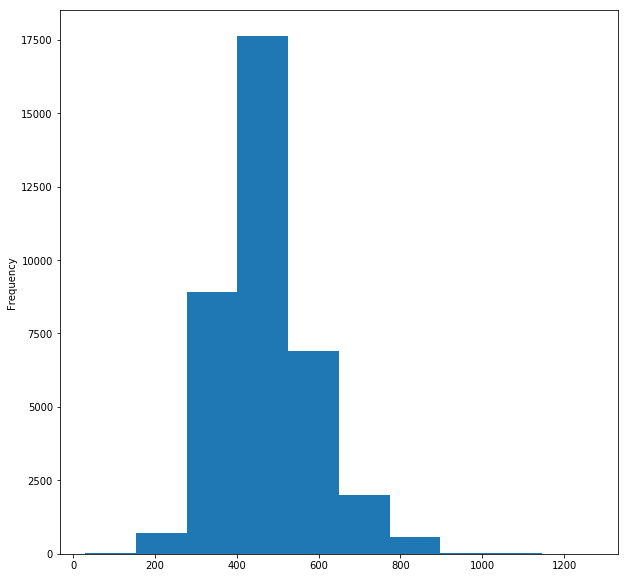

In [8]:
vehiculos['co2'].plot.hist();

Alternativamente, podemos hacer un gráfico KDE , o Kernel Density Estimate, que produce una funcion estimada de la distribución de la variable ([Función de densidad de probabilidad](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_densidad_de_probabilidad)).

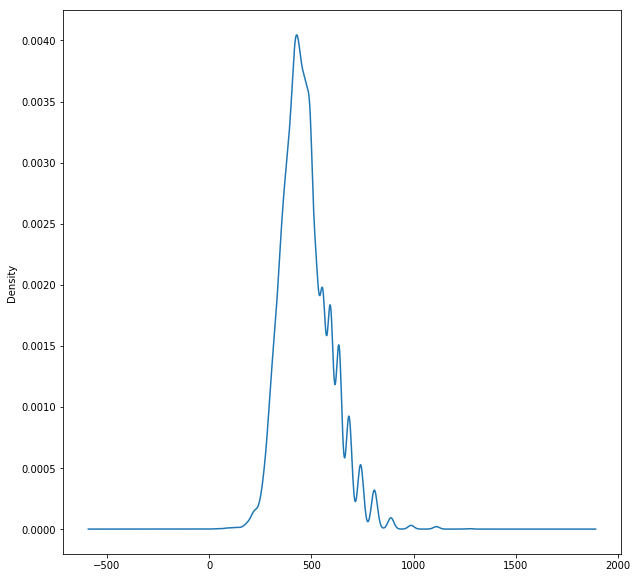

In [9]:
vehiculos['co2'].plot.kde();

In [10]:
def distribucion_variable_numerica(df, col):
    df[col].plot.kde()
    plt.xlabel('Distribucion de la variable {}'.format(col))
    plt.show()

Ahora podemos usar `pywidgets` para poder analizar las distribuciones más cómodamente. Tiene sentido hacer estos gráficos solo para variables numéricas. El método `pandas.select_dtypes` devuelve aquellas columnas de unos tipos específicos

In [11]:
columnas_numericas = vehiculos.select_dtypes(['int', 'float']).columns

In [12]:
from ipywidgets import interact, fixed

In [13]:
interact(distribucion_variable_numerica, col=columnas_numericas, df=fixed(vehiculos));

interactive(children=(Dropdown(description='col', options=('year', 'desplazamiento', 'cilindros', 'consumo', '…

Vemos que la variable `cilindros` pese a ser numérica no tiene una distribución equilibrada de valores

In [14]:
vehiculos['cilindros'].value_counts(normalize=True)

4.0     0.381184
6.0     0.350767
8.0     0.220344
5.0     0.020115
12.0    0.015630
3.0     0.006252
10.0    0.004132
2.0     0.001359
16.0    0.000217
Name: cilindros, dtype: float64

In [20]:
../../../media/dnormal.png

SyntaxError: invalid syntax (<ipython-input-20-288520fa5c4a>, line 1)

Parece que gran parte de las variables siguen una distribucion normal. Que las variables sigan una distribución normal es importante dado que muchos algoritmos asumen que la distribución de las variables es normal.

La distribucion normal tiene esta forma:

![dnormal](../../../media/dnormal.png)

Podemos comprobar esto con un [grafico de probabilidad](http://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm).

La funcion de scipy.stats `probplot` compara la distribucion de una variable con una distribucion teorica (la normal por defecto), cuanto más se parezca la gráfica a una linea de 45 grados más normal será.

In [21]:
from scipy import stats

In [22]:
def normalidad_variable_numerica(col):
    stats.probplot(vehiculos[col], plot=plt)
    plt.xlabel('Diagrama de Probabilidad(normal) de la variable {}'.format(col))
    plt.show()

In [23]:
interact(normalidad_variable_numerica, col=columnas_numericas);

interactive(children=(Dropdown(description='col', options=('year', 'desplazamiento', 'cilindros', 'consumo', '…

Parece que siguen una distribución normal, no obstante, conviene asegurarse haciendo un test de normalidad. En un test de normalidad, lo que queremos es rechazar la hipótesis nula de que la variable a analizar se ha obtenido de una población que sigue una distribución normal. Para un nivel de confianza de 95%, rechazamos la hipótesis nula si el p-value es inferior a 0.05. Esto es, si se obtiene un valor P (p-value) menor de 0.05, significa que las probabilidades de que la hipótesis nula sean ciertas es tan baja (menos de un 5%) que la rechazamos.


scipy tiene la función [normaltest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) que devuelve el p-value

In [24]:
for num_col in columnas_numericas:
    _, pval = stats.normaltest(vehiculos[num_col])
    if(pval < 0.05):
        print("Columna {} no sigue una distribución normal".format(num_col))

Columna year no sigue una distribución normal
Columna consumo no sigue una distribución normal
Columna co2 no sigue una distribución normal
Columna consumo_litros_milla no sigue una distribución normal


Con lo cual vemos que ninguna de las variables numéricas siguen una distribución normal correcta.

### Distribución variables categóricas

Una manera de ver como se distribuyen las variables categóricas es mediante la función `pandas.value_counts`. Dicha función nos devuelve el numero de records existentes para cada valor de una columna

In [25]:
def distribucion_variable_categorica(col):
    vehiculos[col].value_counts(ascending=True,normalize=True).tail(20).plot.barh()
    plt.show()

In [26]:
columnas_categoricas = vehiculos.select_dtypes(['object', 'category']).columns

In [27]:
interact(distribucion_variable_categorica, col=columnas_categoricas);

interactive(children=(Dropdown(description='col', options=('fabricante', 'modelo', 'transmision', 'traccion', …

### Conclusiones

- Ninguna variable numérica sigue una distribución normal

- la variable numérica cilindros tiene una distribución de valores discretos no balanceada (cilindrada de 2 y 4 y 8 suman el 95% de los vehiculos). Podria agruparse como variable categórica (2, 4 , 8 y otro)

- El fabricante con la mayor cantidad de modelos es Chevrolet (10% del total)

- 65% de los vehiculos usan gasolina normal

- La distribución de tamaños de motor y de consumo y co2 está equilibrada en todo el rango

- 70% de los vehiculos usan traccion a las dos ruedas

- dos tercios de los coches tienen transmision automática

- La clase mayoritaria de vehiculos es la de coches pequeños (35% del total)
- Los mayores fabricantes en cuanto a vehiculos analizados son los estadounidenses. Esto tiene sentido ya que la EPA es la agencia americana y probablemente es la que tiene más interes en estudiar coches de USA